## Dissecting Spotify Valence

---

> <h4>Konstantina Saketou</h4><br />
> Assignment in Applied Machine Learning <br />
> Management Science and Technology Department <br />
> Athens University of Economics and Business


**Necessary files to execute this notebook:**  
* `charts` (folder) : contains all the songs used for the analysis
* `tracks_with_features.csv` : contains the features of the songs of the `charts` folder
* `spotify_ids.txt` : contains the song ids we will use for further evaluation
* `given_tracks_features.csv` : contains the features of the songs given at the `spotify_ids.txt` file

**To run this notebook, it is necessary to have all the files along with the notebook into the same folder**

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Obtaining and transforming the data

* In order to study valence, we have to get access to several songs and their features.
* Since Spotify doesn't allow scraping, we will use some data for different countries which is available in Zenodo: https://doi.org/10.5281/zenodo.4778562  
    * Gabriel P. Oliveira, Mariana O. Silva, Danilo B. Seufitelli, Anisio Lacerda, and Mirella M. Moro. Detecting Collaboration Profiles in Success-based Music Genre Networks. In Proceedings of the 21st International Society for Music Information Retrieval Conference (ISMIR 2020), 2020.
* From the files provided we download the `charts.zip` file.
* We unzip the file and parse through all its subfolders in order to obtain the data.
* We keep the songs' titles, countries, dates they were at the charts, popularity duration and chart position.

In [2]:
# get charts data
charts = []
for file in glob.glob('Charts/*/201?/*.csv'):
    region = file.split('\\')[1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('res_')[-1])
    weekly_chart = pd.read_csv(file, sep='\t')
    weekly_chart['week_start'] = dates[0]
    weekly_chart['week_end'] = dates[1]
    weekly_chart['region'] = region
    charts.append(weekly_chart)

all_charts = pd.concat(charts)
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,au
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,au
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,au
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,au
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,au
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,us
196,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,us
197,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,us
198,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,us


* After we got basic information about the songs, we now have to get access to some of their features.
* We will use the Spotify API to do that.
* Firstly, we save into `song_ids` the unique Spotify ids of the songs we have. That way, we will avoid duplicate values on the song features.

In [3]:
# find unique song ids
song_ids = list(all_charts.song_id.unique())

* In order to get access to the Spotify API, a Web Application was created.
* We will use the credentials provided from the Web App to get the song features.
* We saved these credentials into a configuration file for safety reasons.
* In order to not share the config file, when we obtained the song features we exported them to a csv file which is provided along with this jupyter notebook and the `charts` dataset used as well.
* The code shown below was used to obtain the song features from the Spotify API.

```
# create spotify client
from config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# get features
features = {}

start = 0
num_tracks = 100
while start < len(song_ids):
    tracks_batch = song_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks
    
tracks_with_features = pd.DataFrame.from_dict(features, orient='index').reset_index()
tracks_with_features.rename(columns={'index':'song_id'}, inplace=True)
```

* The file `tracks_with_features.csv` is provided with this notebook and it contains the downloaded song features.
* So we read the file and save the information into the dataset `tracks_with_features`.

In [4]:
tracks_with_features = pd.read_csv('tracks_with_features.csv')

In [5]:
tracks_with_features

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
1,5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
2,7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3,3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
4,78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,3aQV6E290SJvasp2VOgvBz,0.810,0.690,10,-7.841,0,0.2700,0.03730,0.000000,0.1060,0.6180,139.970,audio_features,3aQV6E290SJvasp2VOgvBz,spotify:track:3aQV6E290SJvasp2VOgvBz,https://api.spotify.com/v1/tracks/3aQV6E290SJv...,https://api.spotify.com/v1/audio-analysis/3aQV...,140369,4
13876,43YQDj1KOPMFAUcTEPKy4p,0.942,0.531,1,-7.510,1,0.2150,0.00236,0.000106,0.0812,0.7400,99.027,audio_features,43YQDj1KOPMFAUcTEPKy4p,spotify:track:43YQDj1KOPMFAUcTEPKy4p,https://api.spotify.com/v1/tracks/43YQDj1KOPMF...,https://api.spotify.com/v1/audio-analysis/43YQ...,157520,4
13877,1985nAkGJf1oOrgHCWftoN,0.762,0.679,4,-7.595,0,0.1920,0.04260,0.000000,0.1860,0.3280,150.051,audio_features,1985nAkGJf1oOrgHCWftoN,spotify:track:1985nAkGJf1oOrgHCWftoN,https://api.spotify.com/v1/tracks/1985nAkGJf1o...,https://api.spotify.com/v1/audio-analysis/1985...,125320,4
13878,7ntUbTIwmwOD6ygCMRZT6e,0.774,0.836,9,-2.323,0,0.1520,0.28800,0.000024,0.0824,0.4940,112.014,audio_features,7ntUbTIwmwOD6ygCMRZT6e,spotify:track:7ntUbTIwmwOD6ygCMRZT6e,https://api.spotify.com/v1/tracks/7ntUbTIwmwOD...,https://api.spotify.com/v1/audio-analysis/7ntU...,201271,4


* We merge the charts data with the songs' features into one dataset, `all_charts`.

In [6]:
all_charts = pd.merge(all_charts, tracks_with_features[['song_id', 'valence', 'danceability', 'energy', 'loudness', 
                                        'tempo', 'liveness', 'instrumentalness']], on='song_id', how='left')

In [7]:
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,au,0.5350,0.681,0.594,-7.028,186.054,0.1340,0.000003
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,au,0.7420,0.720,0.763,-4.068,101.965,0.1800,0.000000
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,au,0.6610,0.748,0.524,-5.599,95.010,0.1110,0.000000
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,au,0.0862,0.735,0.451,-8.374,117.973,0.3250,0.000013
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,au,0.7170,0.670,0.838,-4.031,104.998,0.1590,0.000611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273595,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,us,0.4840,0.785,0.652,-2.607,170.024,0.0697,0.000000
273596,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,us,0.6050,0.758,0.436,-7.269,104.959,0.3350,0.000016
273597,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,us,0.4010,0.732,0.750,-6.366,155.096,0.1090,0.000000
273598,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,us,0.6710,0.687,0.792,-2.749,100.015,0.1670,0.000000


### Get track features of the given Spotify IDs (spotify_ids.txt)

* Before we start our analysis, we will also get the track features of the song IDs we were given from the `spotify_ids.txt` file. 
* These are songs that we will use for further evaluation of our models.
* First of all, we read the file and store the ids into the `spotify_ids` DataFrame.

In [8]:
spotify_ids = pd.read_csv('spotify_ids.txt', header=None)
spotify_ids.columns = ['song_id']
spotify_ids

,song_id
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g
2,0VjIjW4GlUZAMYd2vXMi3b
3,4MzXwWMhyBbmu6hOcLVD49
4,5Kskr9LcNYa0tpt5f0ZEJx
...,...
1157,4lUmnwRybYH7mMzf16xB0y
1158,1fzf9Aad4y1RWrmwosAK5y
1159,3E3pb3qH11iny6TFDJvsg5
1160,3yTkoTuiKRGL2VAlQd7xsC


* We see that 131 of the songs of the `txt` file already exist in the `all_charts` dataframe, so we will remove these songs from `all_charts`

In [9]:
# 131 songs already exist on the initial dataset
spotify_ids.song_id.isin(pd.DataFrame(song_ids)[0]).value_counts()

False    1031
True      131
Name: song_id, dtype: int64

In [10]:
# remove the songs that already exist in the txt file from all_charts dataframe
all_charts['exists'] = (pd.DataFrame(song_ids)[0]).isin(all_charts['song_id'])
all_charts = all_charts.drop(all_charts.loc[all_charts.exists == True].index)
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region,valence,danceability,energy,loudness,tempo,liveness,instrumentalness,exists
13880,81,2Tq2R8sRftNEqdgJK5HadO,My My My!,Troye Sivan,325057,86.0,16,18,5,2018-04-27,2018-05-04,au,0.462,0.699,0.479,-7.830,102.959,0.0435,0.000096,NaN
13881,82,7m9OqQk4RVRkw9JJdeAw96,Jocelyn Flores,XXXTENTACION,319964,88.0,36,13,6,2018-04-27,2018-05-04,au,0.437,0.872,0.391,-9.144,134.021,0.2970,0.000004,NaN
13882,83,7oK9VyNzrYvRFo7nQEYkWN,Mr. Brightside,The Killers,319175,101.0,70,54,18,2018-04-27,2018-05-04,au,0.232,0.356,0.924,-3.740,148.017,0.0953,0.000000,NaN
13883,84,3Vo4wInECJQuz9BIBMOu8i,Finesse - Remix; feat. Cardi B,Bruno Mars,319169,76.0,17,4,-8,2018-04-27,2018-05-04,au,0.926,0.704,0.859,-4.877,105.115,0.0215,0.000000,NaN
13884,85,1quuqraz6z6RusyJZtyDcm,Just Friends,Hayden James,315410,NaN,1,85,new,2018-04-27,2018-05-04,au,0.363,0.639,0.685,-4.571,110.041,0.1430,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273595,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,us,0.484,0.785,0.652,-2.607,170.024,0.0697,0.000000,NaN
273596,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,us,0.605,0.758,0.436,-7.269,104.959,0.3350,0.000016,NaN
273597,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,us,0.401,0.732,0.750,-6.366,155.096,0.1090,0.000000,NaN
273598,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,us,0.671,0.687,0.792,-2.749,100.015,0.1670,0.000000,NaN


* Now we will get the features of the songs of the `txt` file using the Spotify Web Application we created
* Again in order to not share the Spotify credentials, we get the features the same way we did before.
* We save the features into the `given_tracks_features.csv` file, which is provided along with this notebook.
* Below we can see the code used to access the songs' features

```
#create spotify client
from config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#get features
features = {}
all_track_ids = list(spotify_ids['song_id'])

start = 0
num_tracks = 100
while start < len(spotify_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks
    
given_tracks_features = pd.DataFrame.from_dict(features, orient='index').reset_index()
given_tracks_features.rename(columns={'index':'song_id'}, inplace=True)
```

In [11]:
# get song features from the csv provided with this notebook
given_tracks_features = pd.read_csv('given_tracks_features.csv')

In [12]:
given_tracks_features

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4
1,5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
2,0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
3,4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,audio_features,4MzXwWMhyBbmu6hOcLVD49,spotify:track:4MzXwWMhyBbmu6hOcLVD49,https://api.spotify.com/v1/tracks/4MzXwWMhyBbm...,https://api.spotify.com/v1/audio-analysis/4MzX...,205090,4
4,5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,audio_features,5Kskr9LcNYa0tpt5f0ZEJx,spotify:track:5Kskr9LcNYa0tpt5f0ZEJx,https://api.spotify.com/v1/tracks/5Kskr9LcNYa0...,https://api.spotify.com/v1/audio-analysis/5Ksk...,205458,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,4lUmnwRybYH7mMzf16xB0y,0.596,0.650,9,-5.167,1,0.3370,0.13800,0.000000,0.1400,0.188,133.997,audio_features,4lUmnwRybYH7mMzf16xB0y,spotify:track:4lUmnwRybYH7mMzf16xB0y,https://api.spotify.com/v1/tracks/4lUmnwRybYH7...,https://api.spotify.com/v1/audio-analysis/4lUm...,257428,4
1158,1fzf9Aad4y1RWrmwosAK5y,0.588,0.850,4,-6.431,1,0.0318,0.16800,0.002020,0.0465,0.768,93.003,audio_features,1fzf9Aad4y1RWrmwosAK5y,spotify:track:1fzf9Aad4y1RWrmwosAK5y,https://api.spotify.com/v1/tracks/1fzf9Aad4y1R...,https://api.spotify.com/v1/audio-analysis/1fzf...,187310,4
1159,3E3pb3qH11iny6TFDJvsg5,0.754,0.660,0,-6.811,1,0.2670,0.17900,0.000000,0.1940,0.316,83.000,audio_features,3E3pb3qH11iny6TFDJvsg5,spotify:track:3E3pb3qH11iny6TFDJvsg5,https://api.spotify.com/v1/tracks/3E3pb3qH11in...,https://api.spotify.com/v1/audio-analysis/3E3p...,209299,4
1160,3yTkoTuiKRGL2VAlQd7xsC,0.584,0.836,0,-4.925,1,0.0790,0.05580,0.000000,0.0663,0.484,104.973,audio_features,3yTkoTuiKRGL2VAlQd7xsC,spotify:track:3yTkoTuiKRGL2VAlQd7xsC,https://api.spotify.com/v1/tracks/3yTkoTuiKRGL...,https://api.spotify.com/v1/audio-analysis/3yTk...,202204,4


**Prepare the given songs for testing**
* Since we will use the data of `given_tracks_features` to evaluate our models, we will separate them into `y_test_given` and `X_test_given`
    * `X_test_given` contains the songs' features 
    * `y_test_given` contains valence's values

In [13]:
y_test_given = given_tracks_features['valence']
X_test_given = given_tracks_features.loc[:,('danceability', 'energy', 'loudness', 'tempo', 'liveness', 'instrumentalness')]

* From now on, we will use the two above dataframes when we want to evaluate our models with the songs given in the `txt` file

### Q1: Expore which Features Influence Valence

* We will see how different song features influence a song's valence. We will specifically analyze the below features:
    * danceability
    * energy
    * loudness
    * tempo
    * liveness
    * instrumentalness  

* We firstly check the impact on valence of each feature separately, without taking into consideration the combination of the features yet.  
* We gather all the features we will analyze in the `analysis_data` dataframe, including the valence metric.  

In [14]:
analysis_data = all_charts.loc[:,('valence', 'danceability', 'energy', 'loudness',
                                        'tempo', 'liveness', 'instrumentalness')].copy()

* We perform the analysis using linear regression. Our dependent variable is valence and we consider all the above features being the independent variables.

**Danceability**  
We see that the danceability of a song is positively related with the valence metric. More specifically, if the danceability of a song is equal to zero, the song is considered sad with a valence of 0,22.

In [15]:
regr_danceability = smf.ols("valence ~ danceability", data=analysis_data)
danceability_res = regr_danceability.fit()
danceability_res.params

Intercept       0.223785
danceability    0.405612
dtype: float64

**Energy**  
The energy metric seems to have a big impact on the valence of a song. The two metrics are positively related. This means that as the energy of a song increases the valence of a song increases as well and thus, the song's valence moves towards the happy side.

In [16]:
regr_energy = smf.ols("valence ~ energy", data=analysis_data)
energy_res = regr_energy.fit()
energy_res.params

Intercept    0.185436
energy       0.486039
dtype: float64

**Lowdness**  
The lowdness of a song seems to have a small impact on the valence metric. However, when the lowdness is zero the valence is equal to 0,66 and the song is considered realtively happy.

In [17]:
regr_loudness = smf.ols("valence ~ loudness", data=analysis_data)
loudness_res = regr_loudness.fit()
loudness_res.params

Intercept    0.664547
loudness     0.026666
dtype: float64

**Tempo**  
We see that the impact of the tempo on the valence metric is almost equal to zero. Also, in that case the valence is equal to 0,5 which is a value that doesn't provide much information on the happiness of the song.

In [18]:
regr_tempo = smf.ols("valence ~ tempo", data=analysis_data)
tempo_res = regr_tempo.fit()
tempo_res.params

Intercept    0.501477
tempo        0.000015
dtype: float64

**Liveness**  
Similar to tempo, the liveness metric doesn't seem to influence the valence of the song very much. Liveness' impact is almost zero with the value of valence being again almost 0,5.

In [19]:
regr_liveness = smf.ols("valence ~ liveness", data=analysis_data)
liveness_res = regr_liveness.fit()
liveness_res.params

Intercept    0.48967
liveness     0.07568
dtype: float64

**Instrumentalness**  
The instrumentalness feature seems to be negatively related to the song's valence, which means that as the instrumentalness increases the valence of the song decreases. However, in case we have zero instrumentalness the valence is equal to 0,5, which doesn't provide much information about the hapiness/sadness of the song.

In [20]:
regr_instrumentalness = smf.ols("valence ~ instrumentalness", data=analysis_data)
instrumentalness_res = regr_instrumentalness.fit()
instrumentalness_res.params

Intercept           0.505278
instrumentalness   -0.286619
dtype: float64

<hr>

* Having seen the impact on valence of each individual feature, we notice that a few of them seem to have a bigger impact than others. 
* To analyze the overall impact of the features on the songs' happiness, we will perform multiple linear regression. Our dependent variable is valence and the independent ones are danceability, energy, loudness, tempo, liveness and instrumentalness.

In [21]:
multiple_reg = smf.ols("valence ~ danceability + energy + loudness + tempo + "
                       "+ liveness + instrumentalness", data=analysis_data)
multiple_res = multiple_reg.fit()

* Before we assess the R-squared of the model, we will first check the residuals to see if our dependence assumption is true.
* From the QQ plot below, we notice that the majority of the residuals lie on the diagonal line. This means that there is small difference between the observed and the fitted values of the model

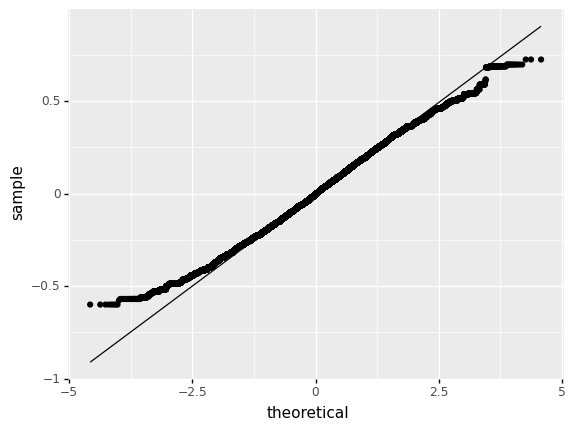

<ggplot: (143512897509)>

In [22]:
from plotnine import *

ggplot(data=multiple_res.resid.to_frame().rename(columns={0: 'resid'})) +\
    geom_qq(mapping=aes(sample='resid')) +\
    geom_qq_line(mapping=aes(sample='resid'))

* We now see that the model's R-squared is equal to 21%. This means that the below features explain the 21% of a song's valence.
* By observing the model's parameters, we see that they are not very far from the ones we saw at the individual analysis of the features. Danceability and energy continue to be significantly positively related to valence, whereas instrumentalness is again negatively related to the song's happiness. 
* Tempo is also negatively related to valence, however with a very small impact which is close to zero.

In [23]:
multiple_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.210       
Dependent Variable: valence          AIC:                -124118.7295
Date:               2022-02-24 21:35 BIC:                -124045.4580
No. Observations:   259720           Log-Likelihood:     62066.      
Df Model:           6                F-statistic:        1.147e+04   
Df Residuals:       259713           Prob (F-statistic): 0.00        
R-squared:          0.210            Scale:              0.036305    
---------------------------------------------------------------------
                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept            -0.0881   0.0043 -20.3599 0.0000 -0.0966 -0.0796
danceability          0.4333   0.0028 154.9943 0.0000  0.4278  0.4387
energy                0.4859   0.0034 141.5372 0.0000  0.4792  0.4926
loudness              0.0012   0.0002   4.9007 0.0000  0.0007  0.0016
tempo                -0.0002   0.0000 -14.9558 0.0000 -0.0002 -0.0002
liveness              0.0439   0.0025  17.4736 0.0000  0.0389  0.0488
instrumentalness     -0.1872   0.0073 -25.7426 0.0000 -0.2015 -0.1730
---------------------------------------------------------------------
Omnibus:              1823.374       Durbin-Watson:          1.894   
Prob(Omnibus):        0.000          Jarque-Bera (JB):       1342.733
Skew:                 0.073          Prob(JB):               0.000   
Kurtosis:             2.680          Condition No.:          2424    
=====================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

## Q2: Predict Valence

* We will use three methods to try and predict the valence based on our data.
* These are:
    * Decision Trees
    * Random Forests
    * Stochastic Gradient Descent

### 1) Decision Trees

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from io import StringIO
from IPython.display import Image
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem
import pydotplus
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

* After we import the necessary libraries, we gather the data we will need into the `data` DataFrame.
* More specificaly, we keep the columns of the six features we are analyzing and also the valence column which we want to predict.
* Then we split the dataset into training and testing set using the `train_test_split` method.
* The training set will be the 80% of the data and the testing set will be the 20%.

In [25]:
data = all_charts.loc[:,('valence', 'danceability', 'energy', 'loudness', 'tempo', 'liveness', 'instrumentalness')].copy()

X = data.loc[:,'danceability':'instrumentalness']
y = data['valence']

# Split the dataset into a training (80%) and a testing (20%) set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

* In order to get an estimation of the best depth of the tree, we run k-fold validation to get the scores of different depth values
* We notice that the score keeps increasing as the depth gets bigger. However, for our analysis we will use `max_depth=6`, since at this level there is a relatively high mean score and a low Standard Error, compared to other values.

In [26]:
all_depths = []
all_mean_scores = []

valence_data = y_train
xs = X_train

for max_depth in range(1, 11):
    all_depths.append(max_depth)
    simple_tree = DecisionTreeRegressor(max_depth=max_depth)
    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = cross_val_score(simple_tree, xs, valence_data, cv=cv)
    mean_score = np.mean(scores)
    all_mean_scores.append(np.mean(scores))
    print("max_depth = ", max_depth, scores, mean_score, sem(scores))

max_depth =  1 [0.09800672 0.09689049 0.09712663 0.09964236 0.09719805] 0.09777284887359325 0.0005038013335084556
max_depth =  2 [0.17473497 0.17065664 0.16913091 0.17723199 0.1709545 ] 0.17254180159693294 0.0014919013696505033
max_depth =  3 [0.21038498 0.20689267 0.20391814 0.21161273 0.20761536] 0.20808477513669557 0.0013553544264924878
max_depth =  4 [0.25844619 0.25421659 0.25509164 0.25981298 0.25096909] 0.2557072978738433 0.0015717822860695627
max_depth =  5 [0.30867611 0.30269448 0.30347253 0.30605223 0.30841075] 0.3058612172606241 0.0012287042668349096
max_depth =  6 [0.35108321 0.35165753 0.35297214 0.35412444 0.35643   ] 0.3532534656590868 0.000953548494312478
max_depth =  7 [0.4080342  0.41289975 0.41432935 0.41082279 0.41483648] 0.4121845136271201 0.0012494840066739604
max_depth =  8 [0.47130877 0.4716413  0.47833417 0.47343344 0.48129066] 0.47520166870501707 0.001972889684177602
max_depth =  9 [0.54088789 0.53612594 0.54270883 0.54105976 0.53888934] 0.539934352130947 0.00

* We then fit the model to our training data.
* Below we can see the resulting Decision Tree.

In [27]:
# fit the model
valence_tree = DecisionTreeRegressor(max_depth=6)
valence_tree.fit(xs.values, valence_data)

DecisionTreeRegressor(max_depth=6)

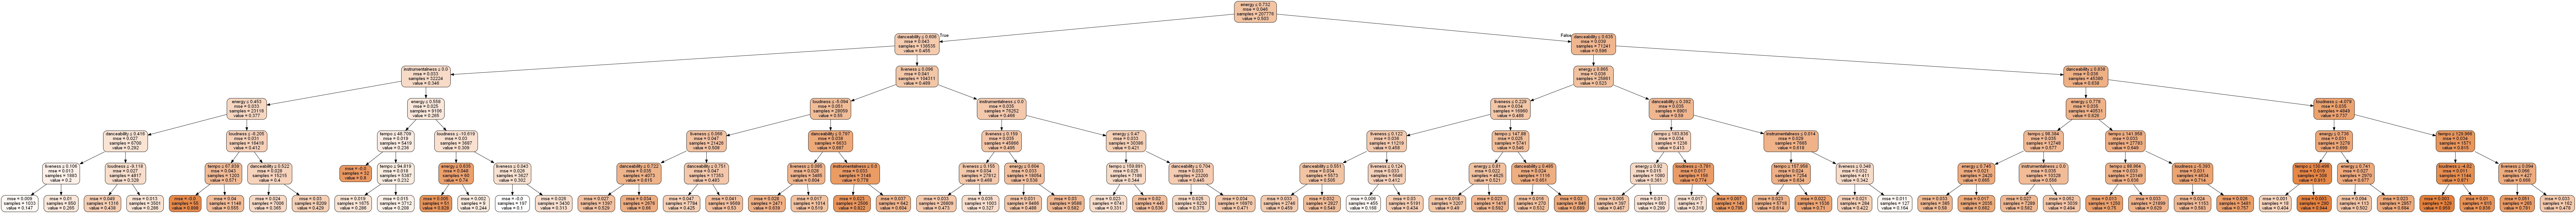

In [28]:
dot_data = StringIO()  
tree.export_graphviz(DecisionTreeRegressor(max_depth=6).fit(xs, valence_data), out_file=dot_data,
                     special_characters=True, filled=True, rounded=True, feature_names=xs.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

* We can also see the importance of each individual feature based on our model
* We see that the results are similar to the ones of the multiple linear regression we performed in Q1.
* Energy and danceability have the highest importance and influence on valence, whereas tempo has the smallest impact.

In [29]:
# Get the feature importances
importances = valence_tree.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(xs.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], 
                                      xs.columns[indices[f]], 
                                      importances[indices[f]]))

1. feature 1 energy (0.372154)
2. feature 0 danceability (0.302697)
3. feature 4 liveness (0.118126)
4. feature 2 loudness (0.080445)
5. feature 5 instrumentalness (0.075615)
6. feature 3 tempo (0.050963)


* We will plot the feature importances to better visualize them

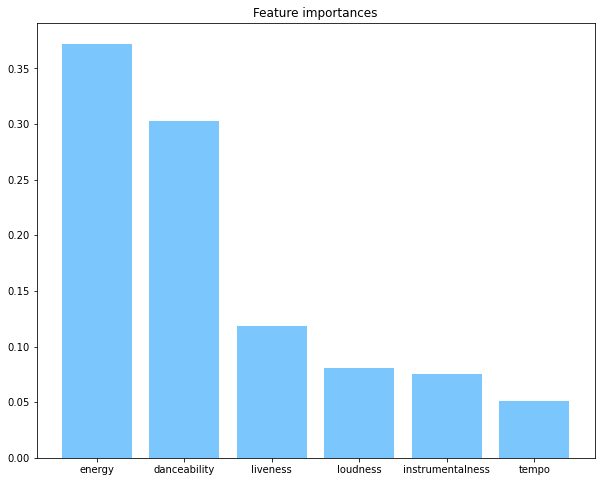

In [30]:
# Plot the feature importances 
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(xs.shape[1]), importances[indices],
        tick_label=[xs.columns[x] for x in indices],
        color="#7CC6FE")
plt.show()

**Evaluate Model with the 20% of the dataset**

* We will now use the testing set we created in order to evaluate our model
* First, we save our model's predictions into the `y_pred` array

In [31]:
y_pred  = valence_tree.predict(X_test)
y_pred

array([0.59167207, 0.57986234, 0.42526522, ..., 0.47327164, 0.31341087,
       0.6840895 ])

* Since we will use the `metrics.accuracy_score` and `metrics.classification_report` we can't use continuous values, thus we will transform the `y_pred` and `y_test` values like so:
    * We will separate the predictions into two possible results: `Happy Song` and `Sad Song`
    * If a song's valence is higher than `0.5`, then the song is considered to be a happy one (value = 1).
    * In case valence is lower than or equal to `0.5`, the song is considered sad (value = 0).
* Below we can see the final `y_pred` and `y_test` DataFrames.

In [32]:
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred>0.5
y_pred.replace(True, 1, inplace=True)
y_pred.replace(False, 0, inplace = True)
y_pred

,0
0,1
1,1
2,0
3,1
4,0
...,...
51939,0
51940,1
51941,0
51942,0


In [33]:
y_test = pd.DataFrame(y_test)
y_test = y_test>0.5
y_test.replace(True, 1, inplace=True)
y_test.replace(False, 0, inplace = True)
y_test

,valence
206991,1
149509,1
211718,0
23833,0
247458,0
...,...
14031,0
78448,0
192981,0
101100,0


* We see that our model achieves an accuracy score of **71.5%**.
* From the classification report, we see a precision of 74% on Happy Songs. This means that the 74% of the Happy predicitons where truly correct.
* Same thing happens on Sad Songs, where 70% of the predictions where truly correct.
* Also, the Mean Absolute Error is equal to 0.28 which is pretty low

In [34]:
metrics.accuracy_score(y_test, y_pred)

0.7159055906360696

In [35]:
print(metrics.classification_report(y_test, y_pred, target_names=['Sad Song', 'Happy Song']))

              precision    recall  f1-score   support

    Sad Song       0.70      0.79      0.74     26606
  Happy Song       0.74      0.64      0.69     25338

    accuracy                           0.72     51944
   macro avg       0.72      0.71      0.71     51944
weighted avg       0.72      0.72      0.71     51944



In [36]:
mean_absolute_error(y_pred, y_test)

0.2840944093639304

**Evaluate Model with the data of `spotify_ids.txt` file**

* Now we will use the external data of the `spotify_ids.txt` file to evaluate our model again.
* We use as input data the `X_test_given` DataFrame and we save our predictions into the `y_pred_given` array

In [37]:
y_pred_given  = valence_tree.predict(X_test_given)
y_pred_given

array([0.20811191, 0.62937063, 0.31341087, ..., 0.58178528, 0.54917863,
       0.20811191])

* We will modify again both `y_pred_given` and `y_test_given` like we did above in order to get the accuracy and classification report
    * 1 = Happy Song
    * 0 = Sad Song

In [38]:
y_pred_changed = pd.DataFrame(y_pred_given)
y_pred_changed = y_pred_changed>0.5
y_pred_changed.replace(True, 1, inplace=True)
y_pred_changed.replace(False, 0, inplace = True)
y_pred_changed

,0
0,0
1,1
2,0
3,0
4,0
...,...
1157,0
1158,1
1159,1
1160,1


In [39]:
y_test_changed = pd.DataFrame(y_test_given)
y_test_changed = y_test_changed>0.5
y_test_changed.replace(True, 1, inplace=True)
y_test_changed.replace(False, 0, inplace = True)
y_test_changed

,valence
0,0
1,1
2,0
3,0
4,0
...,...
1157,0
1158,1
1159,0
1160,0


* By evaluating our model we get an accuracy score of 67%
* **The Mean Absolute Error is equal to 0.329**
* This is a relatively low value for the MAE

In [40]:
metrics.accuracy_score(y_test_changed, y_pred_changed)

0.6703958691910499

In [41]:
mean_absolute_error(y_pred_changed, y_test_changed)

0.32960413080895007

### 2) Random Forests

* The second method we will use is Random Forests.
* We will first gather the song features and valence into `forest_data`

In [42]:
forest_data = all_charts.loc[:,'valence':'instrumentalness'].copy()

* By looking at some basic descriptive statistics of the data we notice that the Standard Deviation ranges in different scales

In [43]:
forest_data.describe()

,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
count,259720.000000,259720.000000,259720.000000,259720.000000,259720.000000,259720.000000,259720.000000
mean,0.503253,0.689002,0.653892,-6.048771,121.109785,0.179475,0.007067
std,0.214308,0.135532,0.159575,2.301966,28.019286,0.151781,0.051820
min,0.035400,0.118000,0.005430,-34.475000,46.489000,0.019700,0.000000
25%,0.344000,0.605000,0.544000,-7.230000,98.994000,0.094900,0.000000
50%,0.494000,0.700000,0.666000,-5.777500,119.989000,0.123000,0.000000
75%,0.668000,0.783000,0.778000,-4.516000,139.986000,0.200000,0.000011
max,0.982000,0.980000,0.999000,1.107000,212.117000,0.990000,0.960000


* We will normalize the data using `MinMaxScaler`.

In [44]:
x = forest_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
forest_scaled = pd.DataFrame(x_scaled)
forest_scaled.columns = forest_data.columns
forest_scaled

,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
0,0.450666,0.674014,0.476635,0.748834,0.340945,0.024528,0.000100
1,0.424255,0.874710,0.388065,0.711905,0.528486,0.285788,0.000004
2,0.207691,0.276102,0.924515,0.863779,0.612988,0.077914,0.000000
3,0.940841,0.679814,0.859094,0.831825,0.353962,0.001855,0.000000
4,0.346081,0.604408,0.683968,0.840425,0.383703,0.127074,0.000000
...,...,...,...,...,...,...,...
259715,0.473907,0.773782,0.650754,0.895621,0.745858,0.051530,0.000000
259716,0.601733,0.742459,0.433356,0.764600,0.353020,0.324951,0.000017
259717,0.386224,0.712297,0.749389,0.789978,0.655729,0.092033,0.000000
259718,0.671456,0.660093,0.791660,0.891631,0.323170,0.151809,0.000000


* However, `RandomForestClassifier` does not accept continuous values. That means that we have to transform them to integers.
* We will first transform the instrumentalness feature separately since it has much smaller decimal values than the others. 

* We save the instrumentalness data along with valence into the `instrumentalness` DataFrame.
* Then we move the decimal point of instrumentalness values to the right by five points.
* Finally, we round the values to zero decimal points giving them an interger format.

In [45]:
# modify instrumentalness data
instrumentalness = forest_scaled.loc[:,('valence', 'instrumentalness')].copy()
instrumentalness['instrumentalness'] = ((instrumentalness.instrumentalness)*100000).round(0)
instrumentalness

,valence,instrumentalness
0,0.450666,10.0
1,0.424255,0.0
2,0.207691,0.0
3,0.940841,0.0
4,0.346081,0.0
...,...,...
259715,0.473907,0.0
259716,0.601733,2.0
259717,0.386224,0.0
259718,0.671456,0.0


* We will now round the rest of the features to one decimal point and then multiply them by ten in order to give them an integer format.

In [46]:
forest_scaled = (forest_scaled).round(1)*10
forest_scaled

,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
0,5.0,7.0,5.0,7.0,3.0,0.0,0.0
1,4.0,9.0,4.0,7.0,5.0,3.0,0.0
2,2.0,3.0,9.0,9.0,6.0,1.0,0.0
3,9.0,7.0,9.0,8.0,4.0,0.0,0.0
4,3.0,6.0,7.0,8.0,4.0,1.0,0.0
...,...,...,...,...,...,...,...
259715,5.0,8.0,7.0,9.0,7.0,1.0,0.0
259716,6.0,7.0,4.0,8.0,4.0,3.0,0.0
259717,4.0,7.0,7.0,8.0,7.0,1.0,0.0
259718,7.0,7.0,8.0,9.0,3.0,2.0,0.0


* Now we will merge the instrumentalness column we edited separately into the `forest_scaled` dataframe which contains the rest of the features.

In [47]:
forest_scaled = forest_scaled.join(instrumentalness, lsuffix='_left', rsuffix='_right')
forest_scaled.drop(['instrumentalness_left', 'valence_right'], axis=1, inplace=True)
forest_scaled.columns =['valence', 'danceability', 'energy', 'loudness', 'tempo', 'liveness', 'instrumentalness']
forest_scaled

,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
0,5.0,7.0,5.0,7.0,3.0,0.0,10.0
1,4.0,9.0,4.0,7.0,5.0,3.0,0.0
2,2.0,3.0,9.0,9.0,6.0,1.0,0.0
3,9.0,7.0,9.0,8.0,4.0,0.0,0.0
4,3.0,6.0,7.0,8.0,4.0,1.0,0.0
...,...,...,...,...,...,...,...
259715,5.0,8.0,7.0,9.0,7.0,1.0,0.0
259716,6.0,7.0,4.0,8.0,4.0,3.0,2.0
259717,4.0,7.0,7.0,8.0,7.0,1.0,0.0
259718,7.0,7.0,8.0,9.0,3.0,2.0,0.0


* We will now split the dataset into training (80%) and testing (20%) sets using the `train_test_split` method.

In [48]:
X = forest_scaled.loc[:,'danceability':'instrumentalness']
y = forest_scaled['valence']

# Split the dataset into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

* Then we fit the model which gives us a mean score of 75.9%.

In [49]:
from sklearn.ensemble import RandomForestClassifier
feature_cols = ('danceability', 'energy', 'loudness', 'tempo', 'liveness', 'instrumentalness')
forest = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
scores = cross_val_score(forest, X_train.loc[:, feature_cols], y_train, cv=5)
scores.mean()    

0.7597412690613792

* Below we see the importances of each feature based on our model
* We see that they are different than the ones of the Decision Tree model
* More specifically, we see that tempo is the most important feature along with instrumentalness, whereas loudness is the least important one.

In [50]:
X = forest_scaled.loc[:, feature_cols]
y =  forest_scaled['valence']

forest.fit(X, y)
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], feature_cols[indices[f]], importances[indices[f]]))

1. feature 3 tempo (0.242145)
2. feature 5 instrumentalness (0.195808)
3. feature 4 liveness (0.176289)
4. feature 0 danceability (0.165904)
5. feature 1 energy (0.150246)
6. feature 2 loudness (0.069608)


* We plot the importances to better visualize them

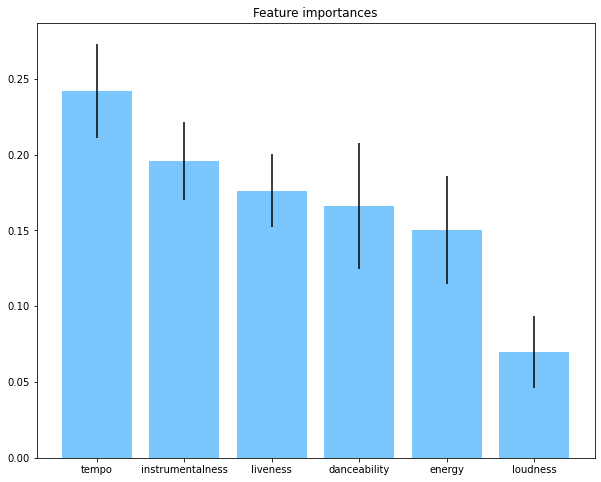

In [51]:
# Plot the feature importances of the random forest
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(xs.shape[1]), importances[indices],
        tick_label=[xs.columns[x] for x in indices],
        color="#7CC6FE", yerr=std[indices], align="center")
plt.show()

**Evaluate Model with the 20% of the dataset**

* We will now use the testing set we created in order to evaluate our model
* First, we save our model's predictions for the `X_test` data into the `y_pred` array
* The model achieves an accuracy of **76.7%** with the Mean Absolute Error (MAE) being equal to 0.57

In [52]:
y_pred = forest.predict(X_test)
metrics.accuracy_score(y_pred,y_test)

0.7674996149699677

In [53]:
mean_absolute_error(y_pred, y_test)

0.5723278915755429

**Evaluate Model with the data of `spotify_ids.txt` file**

* We will now evaluate our model again using the external songs from the `spotify_ids.txt` file
* However, we have to modify the `y_test_given` and `X_test_given` datasets accordingly
* First, we normalize the values using `MinMaxScaler`

In [54]:
# modify X_test_given values
x = X_test_given.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_test_given_changed = pd.DataFrame(x_scaled)
X_test_given_changed.columns = X_test_given.columns

# modify y_test_given values
x = pd.DataFrame(y_test_given.values)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y_test_given_changed = pd.DataFrame(x_scaled)

* We want to give our data an integer format so we round them into one decimal point and then multiply them by ten
* Then we transform again the instrumentalness column separately and we join it with the rest of the data

In [55]:
X_test_given_changed = (X_test_given_changed).round(1)*10

In [56]:
# modify instrumentalness data
instrumentalness = X_test_given_changed.loc[:,'instrumentalness'].copy()
instrumentalness = ((instrumentalness)*100000).round(0)

In [57]:
X_test_given_changed = X_test_given_changed.join(instrumentalness, lsuffix='_left', rsuffix='_right')
X_test_given_changed.drop(['instrumentalness_left'], axis=1, inplace=True)
X_test_given_changed.columns =[ 'danceability', 'energy', 'loudness', 'tempo', 'liveness', 'instrumentalness']
X_test_given_changed

,danceability,energy,loudness,tempo,liveness,instrumentalness
0,5.0,4.0,6.0,6.0,1.0,0.0
1,6.0,8.0,8.0,4.0,5.0,0.0
2,4.0,7.0,8.0,8.0,1.0,0.0
3,7.0,6.0,6.0,4.0,1.0,0.0
4,9.0,4.0,7.0,4.0,1.0,0.0
...,...,...,...,...,...,...
1157,5.0,6.0,8.0,5.0,1.0,0.0
1158,5.0,9.0,7.0,3.0,0.0,0.0
1159,7.0,7.0,7.0,2.0,2.0,0.0
1160,5.0,8.0,8.0,4.0,0.0,0.0


* We also round the valence's values and then multiply them by ten

In [58]:
y_test_given_changed = (y_test_given_changed).round(1)*10
y_test_given_changed

,0
0,1.0
1,6.0
2,3.0
3,1.0
4,2.0
...,...
1157,2.0
1158,8.0
1159,3.0
1160,5.0


* Now that our data is ready, we give them as input on our random forest model and we save the predictions into `y_pred_given`
* We get an accuracy score of 16.7%
* **The Mean Absolute Error (MAE) is equal to 2.19**

In [59]:
y_pred_given = forest.predict(X_test_given_changed)
metrics.accuracy_score(y_pred_given, y_test_given_changed)

0.16092943201376936

In [60]:
mean_absolute_error(y_pred_given, y_test_given_changed)

2.1944922547332184

### 3) Stochastic Gradient Descent

* The third method we will use is the Stochastic Gradient Descent Classification.
* In that case, we want to assign the label `Happy` or `Sad` to a song, based on the features of danceability, energy, loudness, tempo, liveness and instrumentalness.
* We gather the songs' features into the `sgd_data` DataFrame

In [61]:
from sklearn.linear_model import SGDClassifier

sgd_data = all_charts.loc[:,'valence':'instrumentalness']

* By looking at some basic descriptive statistics of the data we notice that the Standard Deviation ranges in different scales
* Thus, we will normalize the data using `MinMaxscaler`

In [62]:
sgd_data.describe()

,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
count,259720.000000,259720.000000,259720.000000,259720.000000,259720.000000,259720.000000,259720.000000
mean,0.503253,0.689002,0.653892,-6.048771,121.109785,0.179475,0.007067
std,0.214308,0.135532,0.159575,2.301966,28.019286,0.151781,0.051820
min,0.035400,0.118000,0.005430,-34.475000,46.489000,0.019700,0.000000
25%,0.344000,0.605000,0.544000,-7.230000,98.994000,0.094900,0.000000
50%,0.494000,0.700000,0.666000,-5.777500,119.989000,0.123000,0.000000
75%,0.668000,0.783000,0.778000,-4.516000,139.986000,0.200000,0.000011
max,0.982000,0.980000,0.999000,1.107000,212.117000,0.990000,0.960000


In [63]:
# normalization
x = sgd_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
sgd_scaled = pd.DataFrame(x_scaled)
sgd_scaled.columns = sgd_data.columns
sgd_scaled

,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
0,0.450666,0.674014,0.476635,0.748834,0.340945,0.024528,0.000100
1,0.424255,0.874710,0.388065,0.711905,0.528486,0.285788,0.000004
2,0.207691,0.276102,0.924515,0.863779,0.612988,0.077914,0.000000
3,0.940841,0.679814,0.859094,0.831825,0.353962,0.001855,0.000000
4,0.346081,0.604408,0.683968,0.840425,0.383703,0.127074,0.000000
...,...,...,...,...,...,...,...
259715,0.473907,0.773782,0.650754,0.895621,0.745858,0.051530,0.000000
259716,0.601733,0.742459,0.433356,0.764600,0.353020,0.324951,0.000017
259717,0.386224,0.712297,0.749389,0.789978,0.655729,0.092033,0.000000
259718,0.671456,0.660093,0.791660,0.891631,0.323170,0.151809,0.000000


* After normalizing the data, we will split them into a training (80%) and a testing (20%) set using the `train_test_split` method

In [64]:
# Split the dataset into a training and a testing set
X = sgd_scaled.loc[:,'danceability':'instrumentalness'].copy()
y = sgd_scaled['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

* Since our purpose in Stochastic Gradient Descent is to label the songs (Happy or Sad) based on their features, we will transform our `y_train` values the same way we did on Decision Trees.
    * We have two possible labels for our songs' predictions: `Happy Song` and `Sad Song`
    * If a song's valence is higher than `0.5`, then the song is considered to be a happy one (value = 1).
    * In case valence is lower than or equal to `0.5`, the song is considered sad (value = 0).


In [65]:
y_train = pd.DataFrame(y_train)
y_train = y_train>0.5
y_train.replace(True, 1, inplace=True)
y_train.replace(False, 0, inplace = True)
y_train

,valence
122064,1
96277,0
62713,0
188617,1
137690,0
...,...
223890,0
131650,1
104152,1
199047,1


* Then we fit the model on our training dataset

In [66]:
clf = SGDClassifier(alpha=0.001, max_iter=1000, tol=-np.inf, random_state=13)
clf.fit(X_train, y_train.to_numpy().ravel())

SGDClassifier(alpha=0.001, random_state=13, tol=-inf)

**Evaluate Model with the 20% of the dataset**

* In order to evaluate our model we have to also transform the `y_test` data the same way we did with the `y_train` one
    * 1 = Happy Song
    * 0 = Sad Song

In [67]:
# modify y_test in order to evaluate
y_test = pd.DataFrame(y_test)
y_test = y_test>0.5
y_test.replace(True, 1, inplace=True)
y_test.replace(False, 0, inplace = True)
y_test

,valence
193111,1
135629,1
197838,0
9953,0
233578,0
...,...
151,0
64568,0
179101,0
87220,0


* We predict the happiness of the song using the `X_test` data
* Our model achieves an accuracy of **67.3%**
* From the classification report we see that 65% of the Happy predictions where predicted correctly, and 70% of the Sad ones where predicted correctly as well

In [68]:
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.6737833050977976

In [92]:
print(metrics.classification_report(y_test, y_pred, target_names=['Sad Song', 'Happy Song']))

              precision    recall  f1-score   support

    Sad Song       0.70      0.66      0.68     27274
  Happy Song       0.65      0.68      0.67     24670

    accuracy                           0.67     51944
   macro avg       0.67      0.67      0.67     51944
weighted avg       0.68      0.67      0.67     51944



* We also see that we get a low Mean Absolute Error which is equal to 0.32

In [70]:
mean_absolute_error(y_pred, y_test)

0.3262166949022024

**Evaluate Model with the data of `spotify_ids.txt` file**

* Now we will evaluate our model again but this time using the songs from the `spotify_ids.txt` file.
* We transform the given test valence values again like so:
    * 1 = Happy Song
    * 0 = Sad Song

In [71]:
# modify y_test_given in order to evaluate
y_test_given_changed = pd.DataFrame(y_test_given)
y_test_given_changed = y_test_given_changed>0.5
y_test_given_changed.replace(True, 1, inplace=True)
y_test_given_changed.replace(False, 0, inplace = True)

* We give our model the input test data and we save the predictions into `y_pred_given`
* We get an accuracy of 48.5%
* **The Mean Absolute Error (MAE) is equal to 0.514**

In [72]:
y_pred_given = clf.predict(X_test_given)
metrics.accuracy_score(y_test_given_changed, y_pred_given)

0.4853700516351119

In [73]:
mean_absolute_error(y_pred_given, y_test_given_changed)

0.5146299483648882

<hr>

### Choosing the best method
* By observing the results of the three above methods we used to predict valence, we can say that **the best one is the Decision Tree implementation** (method 1).  
* In this model we achieve a good accuracy and Mean Absolute Error both on our testing dataset and the external data of the given `txt` file.
* The results and the feature importances of this method are also evaluated by the multiple regression we performed on Q1.
* At the table below, we can see the evaluation results of the Decision Tree implementation method 

|    |      Accuracy      |  Mean Absolute Error |
|----------|-------------|------|
| Testing Dataset (20%) |  71.5%| 0.284 |
| `spotify_ids.txt` data |    67%   |   0.329 |

* Below we have the feature importances of the Decision Tree method

In [74]:
importances = valence_tree.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(xs.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], 
                                      xs.columns[indices[f]], 
                                      importances[indices[f]]))

1. feature 1 energy (0.372154)
2. feature 0 danceability (0.302697)
3. feature 4 liveness (0.118126)
4. feature 2 loudness (0.080445)
5. feature 5 instrumentalness (0.075615)
6. feature 3 tempo (0.050963)


* We see that energy and danceability have the highest impact on a song's valence. This is what we also found on the multiple regression model of Q1.
* Instrumentalness and tempo are the two features with the lowest impact on a song's happiness.

<hr>

## Neural Network Implementation

* In order to predict valence, we will also implement a neural network method

In [75]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing as pr

* We gather the data we will need into the `data` DataFrame
* Then we separate our data again into a training (80%) and a testing (20%) set

In [76]:
data = analysis_data.copy()

In [77]:
train_data = data.sample(frac=0.8,random_state=0)
train_data

,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
101433,0.527,0.869,0.485,-5.595,106.028,0.0765,0.000000
142480,0.319,0.560,0.680,-7.648,89.391,0.1160,0.000000
168078,0.405,0.768,0.471,-8.406,131.023,0.2680,0.000000
268219,0.864,0.692,0.809,-4.198,123.911,0.1470,0.000000
99672,0.645,0.683,0.530,-4.918,75.016,0.3940,0.000000
...,...,...,...,...,...,...,...
182203,0.842,0.798,0.675,-5.041,101.956,0.0894,0.000000
124022,0.610,0.858,0.675,-8.843,115.010,0.1720,0.000014
195001,0.608,0.762,0.700,-6.021,116.073,0.1530,0.000016
232094,0.395,0.406,0.934,-6.668,118.823,0.9550,0.000000


In [78]:
test_data = data.drop(train_data.index)
test_data

,valence,danceability,energy,loudness,tempo,liveness,instrumentalness
13882,0.232,0.356,0.924,-3.740,148.017,0.0953,0.000000
13890,0.419,0.752,0.505,-7.621,91.970,0.1040,0.000003
13901,0.567,0.720,0.659,-4.727,105.955,0.0662,0.000000
13907,0.238,0.605,0.813,-4.785,167.997,0.1450,0.114000
13910,0.376,0.645,0.705,-5.008,137.133,0.1280,0.000000
...,...,...,...,...,...,...,...
273569,0.642,0.628,0.484,-7.588,63.476,0.1260,0.000012
273570,0.129,0.585,0.520,-6.136,159.801,0.1310,0.000070
273574,0.754,0.638,0.813,-3.849,112.986,0.3440,0.000000
273584,0.605,0.731,0.650,-5.286,154.968,0.1240,0.000000


* We also keep the target column of valence separate from the other values

In [79]:
train_labels = train_data.pop('valence').values
test_labels = test_data.pop('valence').values

* We notice that there is some variation among the feature columns, so we will have to normalize them.

In [80]:
train_data.describe()

,danceability,energy,loudness,tempo,liveness,instrumentalness
count,207776.000000,207776.000000,207776.000000,207776.000000,207776.000000,207776.000000
mean,0.689034,0.653832,-6.048173,121.105453,0.179680,0.007084
std,0.135566,0.159509,2.302324,28.008046,0.151974,0.052080
min,0.125000,0.005430,-34.475000,46.489000,0.019700,0.000000
25%,0.605000,0.544000,-7.227000,98.994000,0.094900,0.000000
50%,0.700000,0.666000,-5.781000,119.989000,0.123000,0.000000
75%,0.784000,0.777000,-4.516750,139.984000,0.200000,0.000011
max,0.978000,0.999000,1.107000,212.117000,0.990000,0.960000


* We will use TensorFlow's `Normalization()` layer
* This will be the first layer of our neural network. In that way, when the input data get into the network they will firstly pass from the Normalization phase
* Below we create the `normalizer` layer

In [81]:
normalizer = pr.Normalization()
normalizer.adapt(np.array(train_data))
with np.printoptions(precision=2):
    print(normalizer.mean)
    print(normalizer.variance)
    print(normalizer.count)

<tf.Variable 'mean:0' shape=(6,) dtype=float32, numpy=
array([ 6.89e-01,  6.54e-01, -6.05e+00,  1.21e+02,  1.80e-01,  7.08e-03],
      dtype=float32)>
<tf.Variable 'variance:0' shape=(6,) dtype=float32, numpy=
array([1.84e-02, 2.54e-02, 5.30e+00, 7.84e+02, 2.31e-02, 2.71e-03],
      dtype=float32)>
<tf.Variable 'count:0' shape=() dtype=int64, numpy=207776>


* Then we build and compile our model inside the `build_compile_model` function.
* We will build a sequential network.
* The first layer is the one that performs the normalization of the input data.
* We will have two dense layers, one of 64 nodes and one of 32 and then a final output layer.
* The final output layer will have a single unit and no activation function. 
* We don't want an activation function since we are trying to predict a continuous value.
* We also don't want to constraint any of the regression's predictions.

In [94]:
# build model
def build_compile_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

model = build_compile_model()

* Here we can see a summary of the model

In [95]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_3 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,574
Trainable params: 2,561
Non-trainable params: 13
_________________________________________________________________


* We train the model for 100 epochs.
* At each epoch we will perform a validation, keeping 20% of the epoch data.

In [96]:
num_epochs = 100

history = model.fit(
    train_data, 
    train_labels,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1)

Epoch 1/100
5195/5195 [==============================] - 4s 685us/step - loss: 0.1397 - val_loss: 0.1287
Epoch 2/100
5195/5195 [==============================] - 3s 486us/step - loss: 0.1269 - val_loss: 0.1233
Epoch 3/100
5195/5195 [==============================] - 3s 604us/step - loss: 0.1205 - val_loss: 0.1154
Epoch 4/100
5195/5195 [==============================] - 7s 1ms/step - loss: 0.1159 - val_loss: 0.1138
Epoch 5/100
5195/5195 [==============================] - 7s 1ms/step - loss: 0.1129 - val_loss: 0.1136
Epoch 6/100
5195/5195 [==============================] - 7s 1ms/step - loss: 0.1102 - val_loss: 0.1097
Epoch 7/100
5195/5195 [==============================] - 5s 1ms/step - loss: 0.1084 - val_loss: 0.1051
Epoch 8/100
5195/5195 [==============================] - 7s 1ms/step - loss: 0.1067 - val_loss: 0.1041
Epoch 9/100
5195/5195 [==============================] - 7s 1ms/step - loss: 0.1052 - val_loss: 0.1048
Epoch 10/100
5195/5195 [==============================] - 7s 1ms/st

In [85]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

* After training the model, we will plot the evolution of the training error and the validation error.
* The plot shows improvement as well as some degradation on several points.
* However, after some degradation we usually notice some further improvement.

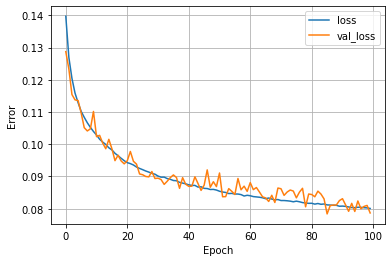

In [97]:
plot_loss(history)

**Evaluate Model with the 20% of the dataset**

* Now we will evaluate the model using the testing set we created which is the 20% of our initial data
* We use the `evaluate` method which gives us the Mean Absolute Error of the model
* **Here we have a Mean Absolute Error (MAE) equal to 0.079**

In [98]:
# mean absolute error - MAE
model.evaluate(test_data, test_labels, verbose=0)

0.07912645488977432

* Below we can see a graphical representation of our predictions based on the testing dataset (20%) against the true valence values

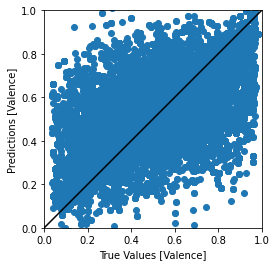

In [99]:
test_predictions = model.predict(test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Valence]')
plt.ylabel('Predictions [Valence]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='black')

**Evaluate Model with the data of `spotify_ids.txt` file**

* Now we will evaluate our model again, but this time using the songs provided from the `spotify_ids.txt` file
* By evaluating with that data, **we get a Mean Absolute Error (MAE) equal to 0.43**

In [100]:
# Mean absolute error - MAE
model.evaluate(y_test_given, y_test_given, verbose=0)

0.43846458196640015

* We also plot the predicted values against the true ones to better visualize them

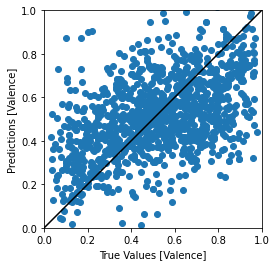

In [101]:
test_predictions = model.predict(X_test_given).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test_given, test_predictions)
plt.xlabel('True Values [Valence]')
plt.ylabel('Predictions [Valence]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='black')

### <div style='text-align:center'> Comparing the results of the Neural Network method with the Decision Tree implementation </div>

| Mean Absolute Errors   |      Neural Network      |  Decision Tree |
|----------|-------------|------|
| Testing Dataset (20%) |  0.079| 0.284 |
| `spotify_ids.txt` data |    0.43   |   0.329 |

From the Neural Network method we get a Mean Error of 0.079 which is a pretty low value. When we evaluate using the `txt` file's data the Mean Error is equal to 0.43, which is a higher value compared to 0.079.  
<br>
The Decision Tree implementation gives as a Mean Error of 0.28 when evaluated on the testing dataset (20%). When evaluated on the `txt` file's songs, the model gives us an error equal to 0.329. The errors of the two different evaluation scenarios are not far from each other. On the contrary, the errors of the two evaluation scenarios at the neural network method show a bigger deviation (0.079 and 0.43).
<br>  
A significant observation is that on the Decision Tree implementation we have a clear picture of the importance of each feature on valence, instead of the neural network method where we have no clue which features have bigger impact and which ones don't. Also, the Decision Tree method's results are somehow similar with the ones of the multiple linear regression we performed at the beggining of our analysis, so in that way we have similar results evaluated by two different methods.
<br>  
However, if we don't take into consideration the evaluation of the models with the `spotify_ids.txt` file, the neural network method seems to have better results than the Decision Tree implementation.  
* Neural Network Error = 0.079
* Decision Tree Error = 0.28